# Adaptive hyperparameter optimization
This notebook shows off a model selection algorithm that is now a part of Dask-ML, Hyperband.

## Problem
Any machine learning model requires tuning many "hyper-parameters" for good performance, and is mentioned in the Scikit-Learn docs under "[Tuning the hyper-parameters of an estimator]".

This notebook will walk through a case of "image denoising". Getting good performance out of this model requires tuning these parameters:

``` python
params = {
    'module__init',
    'module__activation',
    'optimizer',
    'batch_size',
    'optimizer__lr',
    'optimizer__weight_decay',
}
```

These are incredibly important, and fairly basic. They answer the questions of

* How is the network initialization?
* How is the model optimized? What are some of the hyper-parameters for `optimizer`?

[Tuning the hyper-parameters of an estimator]:http://scikit-learn.org/stable/modules/grid_search.html


This notebook looks at a realistic use case of hyperparameter optimization. To do this, this notebook uses

* a realistic deep learning model
* a realistic set of hyperparameters

There are many hyperparameter for any model or framework. These can be specific to the model, or be related to the optimization framework used to minimize the model.

This notebook will show

* the model input and output (noisy and clean images respectively)
* the parameter space we are searching over
* a newly developed hyperparameter optimization algorithm and it's integration
* a comparison with 3 hyperparameter selection algorithms

## Setup

In [ ]:
import warnings
warnings.filterwarnings('ignore') # Reduce number of messages/warnings displayed

In [1]:
# !export PYTHONPATH=../src:$PYTHONPATH
# !echo $PYTHONPATH
!cp -u ../src/noisy_mnist.py . 

In [2]:
%matplotlib inline
# %load_ext autoreload
# %autoreload 2

In [3]:
import distributed
from distributed import Client, LocalCluster

In [4]:
import socket
s=socket.socket()
s.bind(("", 0))
port = s.getsockname()[1]
s.close()

In [5]:
# cluster = LocalCluster(n_workers=-1)
# client = Client(cluster)

# client = Client(f"localhost:{port}")
# client


In [6]:
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster

In [7]:
cluster = LocalCUDACluster(dashboard_address=f"127.0.0.1:{port}")
client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:47347/status,
Dashboard: http://127.0.0.1:47347/status,Workers: 2
Total threads: 2,Total memory: 187.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39291,Workers: 2
Dashboard: http://127.0.0.1:47347/status,Total threads: 2
Started: Just now,Total memory: 187.57 GiB
Comm: tcp://127.0.0.1:39031,Total threads: 1
Dashboard: http://127.0.0.1:38903/status,Memory: 93.78 GiB
Nanny: tcp://127.0.0.1:38973,


In [9]:
import subprocess
def debug_loop():
    # subprocess.call("pip install git+https://github.com/stsievert/dask-ml@hyperband-scale".split(" "))
    import dask_ml
    return dask_ml.__version__

In [10]:
%time debug_loop()

CPU times: user 396 ms, sys: 75.4 ms, total: 471 ms
Wall time: 450 ms


'2023.3.24'

In [11]:
client.run(debug_loop)

{'tcp://127.0.0.1:36329': '2023.3.24', 'tcp://127.0.0.1:39031': '2023.3.24'}

In [12]:
%time client.restart()

2024-01-30 17:11:51,491 - distributed.worker - ERROR - Unexpected exception during heartbeat. Closing worker.
Traceback (most recent call last):
  File "/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/distributed/worker.py", line 1255, in heartbeat
    response = await retry_operation(
  File "/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/distributed/utils_comm.py", line 455, in retry_operation
    return await retry(
  File "/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/distributed/utils_comm.py", line 434, in retry
    return await coro()
  File "/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/distributed/core.py", line 1393, in send_recv_from_rpc
    comm = await self.pool.connect(self.addr)
  File "/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/distributed/core.py", line 1592, in connect
    raise RuntimeError("ConnectionPool is closed")
RuntimeError: Connect

2024-01-30 17:11:51,927 - distributed.nanny - WARNING - Restarting worker
2024-01-30 17:11:52,029 - distributed.nanny - WARNING - Restarting worker


CPU times: user 126 ms, sys: 71.8 ms, total: 197 ms
Wall time: 1.96 s


Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:47347/status,
Dashboard: http://127.0.0.1:47347/status,Workers: 2
Total threads: 2,Total memory: 187.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39291,Workers: 2
Dashboard: http://127.0.0.1:47347/status,Total threads: 2
Started: Just now,Total memory: 187.57 GiB
Comm: tcp://127.0.0.1:39149,Total threads: 1
Dashboard: http://127.0.0.1:34829/status,Memory: 93.78 GiB
Nanny: tcp://127.0.0.1:38973,


In [13]:
# %time client.upload_file('autoencoder.py')
%time client.upload_file('../models/autoencoder.py')

CPU times: user 1.56 s, sys: 330 ms, total: 1.89 s
Wall time: 3.76 s


{'tcp://127.0.0.1:39149': {'status': 'OK'},
 'tcp://127.0.0.1:41087': {'status': 'OK'}}

In [14]:
import dask_ml
from dask_ml.model_selection import HyperbandSearchCV
import dask_ml
print (f'Dask ml version : {dask_ml.__version__}' ) 

Dask ml version : 2023.3.24


## Data
See below for an image.

In [15]:
%load_ext autoreload
%autoreload 2

In [16]:
import noisy_mnist
chunk_size = 70_000 // 3
_X, _y = noisy_mnist.dataset()
_X = _X[:chunk_size * 3]
_y = _y[:chunk_size * 3]

100%|██████████| 9912422/9912422 [00:01<00:00, 6893514.76it/s] 


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 36409886.93it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 1729182.08it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7715888.52it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/home/barradd/Documents/GitHub/RAPIDS_HPO/notebooks/noisy_mnist.py:31: FutureWarning: `seed` is a deprecated argument name for `random_noise`. It will be removed in version 0.23. Please use `rng` instead.
  img = random_noise(x, seed=seed, **noise)


In [17]:
_X.shape, _X.dtype, _X.min(), _X.max()

((69999, 784), dtype('float32'), 0.0, 1.0)

In [18]:
_y.shape, _y.dtype, _y.min(), _y.max()

((69999, 784), dtype('float32'), 0.0, 1.0)

In [19]:
import dask.array as da
n, d = _X.shape
X = da.from_array(_X, chunks=(n // 3, d))
y = da.from_array(_y, chunks=n // 3)
X, y

(dask.array<array, shape=(69999, 784), dtype=float32, chunksize=(23333, 784), chunktype=numpy.ndarray>,
 dask.array<array, shape=(69999, 784), dtype=float32, chunksize=(23333, 784), chunktype=numpy.ndarray>)

/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 69.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 69.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 69.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 69.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and usin

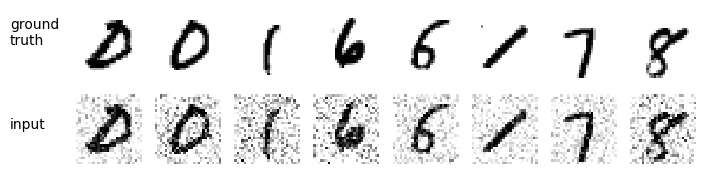

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import check_random_state

rng = check_random_state(42)
cols = 8
w = 1.0
fig, axs = plt.subplots(figsize=(cols*w, 2*w), ncols=cols, nrows=2)
for col, (upper, lower) in enumerate(zip(axs[0], axs[1])):
    if col == 0:
        upper.text(-28, 14, 'ground\ntruth')
        lower.text(-28, 14, 'input')
    i = rng.choice(len(X))
    noisy = X[i].reshape(28, 28)
    clean = y[i].reshape(28, 28)
    kwargs = {'cbar': False, 'xticklabels': False, 'yticklabels': False, 'cmap': 'gray_r'}
    sns.heatmap(noisy, ax=lower, **kwargs)
    sns.heatmap(clean, ax=upper, **kwargs)
plt.savefig("../results/input-output.svg", bbox_inches="tight")
plt.show()

## Model

I use a deep learning library (PyTorch) for this model, at least through the scikit-learn interface for PyTorch, [skorch].

[skorch]:https://github.com/dnouri/skorch

In [22]:
from autoencoder import Autoencoder, NegLossScore
import torch
# from sklearn.model_selection import ParameterSampler
# import torch

def trim_params(**kwargs):
    if kwargs['optimizer'] != 'Adam':
        kwargs.pop('optimizer__amsgrad', None)
    if kwargs['optimizer'] == 'Adam':
        kwargs.pop('optimizer__lr', None)
    if kwargs['optimizer'] != 'SGD':
        kwargs.pop('optimizer__nesterov', None)
        kwargs.pop('optimizer__momentum', None)
    kwargs['optimizer'] = getattr(torch.optim, kwargs['optimizer'])
    return kwargs

class TrimParams(NegLossScore):
    def set_params(self, **kwargs):
        kwargs = trim_params(**kwargs)
        return super().set_params(**kwargs)

model = TrimParams(
    module=Autoencoder,
    criterion=torch.nn.BCELoss,
    warm_start=True,
    train_split=None,
    max_epochs=1,
    callbacks=[]
)

I don't show it here; I'd rather concentrate on tuning hyperparameters. But briefly, it's a simple fully connected 3 hidden layer autoencoder with a latent dimension of 49.

## Parameters

The parameters I am interested in tuning are

* model
    * initialization
    * activation function
    * weight decay (which is similar to $\ell_2$ regularization)
* optimizer
    * which optimizer to use (e.g., Adam, SGD)
    * batch size used to approximate gradient
    * learning rate (but not for Adam)
    * momentum for SGD
    
After looking at the results, I think I was too exploratory in my tuning of step size. I should have experimented with it more to determine a reasonable range.

In [23]:
import numpy as np

params = {
    'module__init': ['xavier_uniform_',
                     'xavier_normal_',
                     'kaiming_uniform_',
                     'kaiming_normal_',
                    ],
    'module__activation': ['ReLU', 'LeakyReLU', 'ELU', 'PReLU'],
    'optimizer': ["SGD"] * 5 + ["Adam"] * 2,
    'batch_size': [32, 64, 128, 256, 512],
    'optimizer__lr': np.logspace(1, -1.5, num=1000),
    'optimizer__weight_decay': [0]*200 + np.logspace(-5, -3, num=1000).tolist(),
    'optimizer__nesterov': [True],
    'optimizer__momentum': np.linspace(0, 1, num=1000),
    'train_split': [None],
}

I am testing `optimizer` to be `SGD` or `Adam` to test "[The Marginal Value of Adaptive Gradient Methods in Machine Learning][marginal]". From their abstract,

> We observe that the solutions found by adaptive methods generalize worse (often sig- nificantly worse) than SGD, even when these solutions have better training performance. These results suggest that practitioners should reconsider the use of adaptive methods to train neural networks.

Their experiments in Figure 1b show that non-adaptive methods (SGD and heavy ball) perform much better than adaptive methods.

They have to do some tuning for this. **Can we replicate their result?**

[marginal]:https://arxiv.org/pdf/1705.08292.pdf

In [ ]:
# # for debugging; ignore this cell
# from sklearn.linear_model import SGDClassifier
# from sklearn.datasets import make_classification
# from sklearn.model_selection import ParameterSampler
# import dask.array as da
# import numpy as np
# model = SGDClassifier()
# params = {'alpha': np.logspace(-7, 0, num=int(1e6))}

# n, d = int(10e3), 700
# _X, _y = make_classification(n_samples=n, n_features=d,
#                              random_state=1)
# X = da.from_array(_X, chunks=(n // 10, d))
# y = da.from_array(_y, chunks=n // 10)
# X, y

In [24]:
import json
# import msgpack

def fmt(obj):
    if isinstance(obj, list):
        return [fmt(v) for v in obj]
    if isinstance(obj, dict):
        return {k: fmt(v) for k, v in obj.items()}
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return obj


In [25]:

import msgpack
# from sklearn.externals import joblib
import dask.array as da

def save_search(search, today, prefix, X, y):
    pre = f"{today}-{prefix}-"

    with open(pre + "test.npz", "wb") as f:
        y_hat = search.predict(X)
        y_hat = y_hat.compute()
        np.savez(f, X=X, y=y, y_hat=y_hat)
    # skorch models aren't pickable
    with open(pre + "params.json", "w") as f:
        params = {k: fmt(v) for k, v in search.get_params().items() if "estimator" not in k and "param_distribution" not in k}
        json.dump(params, f)
    # with open(pre + "best-model.joblib", "wb") as f:
    #     joblib.dump(search.best_estimator_, f)
    with open(pre + "best-params-and-score.json", "w") as f:
        json.dump({"params": search.best_params_, "score": search.best_score_}, f)

    with open(pre + "history.json", 'w') as f:
        json.dump(search.history_, f)

    with open(pre + "cv_results.json", 'w') as f:
        json.dump(fmt(search.cv_results_), f)

In [26]:
from datetime import date

today = date.today()
print("Today's date:", today)

Today's date: 2024-01-30


## Hyperparameter optimization

In [27]:
X

dask.array<array, shape=(69999, 784), dtype=float32, chunksize=(23333, 784), chunktype=numpy.ndarray>

In [28]:
from dask_ml.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_test

(dask.array<concatenate, shape=(62997, 784), dtype=float32, chunksize=(20999, 784), chunktype=numpy.ndarray>,
 dask.array<concatenate, shape=(7002, 784), dtype=float32, chunksize=(2334, 784), chunktype=numpy.ndarray>)

In [29]:
y_train

dask.array<concatenate, shape=(62997, 784), dtype=float32, chunksize=(20999, 784), chunktype=numpy.ndarray>

In [30]:
from sklearn.linear_model import SGDClassifier

max_iter = 243
history = {}
cv_results = {}
searches = {}

In [31]:
from dask_ml.model_selection import HyperbandSearchCV

fit_params = {}
if isinstance(model, SGDClassifier):
    fit_params = {'classes': da.unique(y).compute()}
   

### Hyperband

In [32]:
search = HyperbandSearchCV(model, params, max_iter, random_state=42)

In [ ]:
# model

In [33]:
y_train.shape

(62997, 784)

In [34]:
search.fit(X_train, y_train, **fit_params)

/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 418.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


steps = 1, loss = 0.6946833729743958
steps = 1, loss = 0.7212424874305725
steps = 1, loss = 1.7361098527908325
steps = 1, loss = 1.944223165512085
steps = 1, loss = 2.0238990783691406
steps = 1, loss = 1.9964500665664673
steps = 1, loss = 2.0634427070617676
steps = 1, loss = 1.9778709411621094
steps = 1, loss = 3.272592306137085
steps = 1, loss = 1.0939403772354126
steps = 1, loss = 1.4523916244506836
steps = 1, loss = 1.6960132122039795
steps = 1, loss = 1.9392948150634766
steps = 1, loss = 1.3592060804367065
steps = 1, loss = 2.2068614959716797
steps = 1, loss = 2.3391366004943848
steps = 1, loss = 2.309786796569824
steps = 1, loss = 2.2433576583862305
steps = 1, loss = 2.0454459190368652
steps = 1, loss = 1.9503538608551025
steps = 1, loss = 1.955540418624878
steps = 1, loss = 2.698648691177368
steps = 1, loss = 49.631900787353516
steps = 1, loss = 2.791550397872925
steps = 1, loss = 2.0951931476593018
steps = 1, loss = 49.993465423583984
steps = 1, loss = 1.867989182472229
steps = 

HyperbandSearchCV(estimator=<class '__main__.TrimParams'>[uninitialized](
  module=<class 'autoencoder.Autoencoder'>,
),
                  max_iter=243,
                  parameters={'batch_size': [32, 64, 128, 256, 512],
                              'module__activation': ['ReLU', 'LeakyReLU', 'ELU',
                                                     'PReLU'],
                              'module__init': ['xavier_uniform_',
                                               'xavier_normal_',
                                               'kaiming_uniform_',
                                               'kaiming_normal_'],
                              'optimizer': ['SGD', 'SGD', 'SGD', 'S...
       0.98098098, 0.98198198, 0.98298298, 0.98398398, 0.98498498,
       0.98598599, 0.98698699, 0.98798799, 0.98898899, 0.98998999,
       0.99099099, 0.99199199, 0.99299299, 0.99399399, 0.99499499,
       0.995996  , 0.996997  , 0.997998  , 0.998999  , 1.        ]),
                              'optimizer__nesterov': [True],
                              'optimizer__weight_decay': [0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, ...],
                              'train_split': [None]},
                  random_state=42)

In [35]:
timing_stats = timing_stats = client.profile(filename="hyperband.html")
with open("hyperband-timing.json", "w") as f:
    json.dump(timing_stats[0], f)

In [36]:
search.best_estimator_

<class '__main__.TrimParams'>[initialized](
  module_=Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=784, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Linear(in_features=784, out_features=196, bias=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=196, out_features=784, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Linear(in_features=784, out_features=784, bias=True)
      (3): Sigmoid()
    )
  ),
)

In [37]:
search.best_score_

-1.9581215381622314

In [38]:
search.best_params_

{'train_split': None,
 'optimizer__weight_decay': 0.0007760503335133571,
 'optimizer__nesterov': True,
 'optimizer__momentum': 0.7387387387387387,
 'optimizer__lr': 2.209756114795902,
 'optimizer': 'SGD',
 'module__init': 'kaiming_uniform_',
 'module__activation': 'LeakyReLU',
 'batch_size': 32}

In [39]:
save_search(search, today, "hyperband", X_test.compute(), y_test.compute())

/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 209.35 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 38.43 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


### Hyperband + SOP

In [40]:
search_patience = HyperbandSearchCV(model, params, max_iter, random_state=42, patience=True)

In [41]:
search_patience.fit(X_train, y_train, **fit_params)

/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 418.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


steps = 1, loss = 2.3814570903778076
steps = 1, loss = 1.9917110204696655
steps = 1, loss = 2.2629213333129883
steps = 1, loss = 1.6681660413742065
steps = 1, loss = 2.405320167541504
steps = 1, loss = 1.6678996086120605
steps = 1, loss = 3.259756326675415
steps = 1, loss = 50.00611114501953
steps = 1, loss = 1.9744946956634521
steps = 1, loss = 2.0408871173858643
steps = 1, loss = 1.8700892925262451
steps = 1, loss = 0.7225216627120972
steps = 1, loss = 1.0191717147827148
steps = 81, loss = 2.345111846923828
steps = 81, loss = 2.6572659015655518
steps = 81, loss = 4.885718822479248
steps = 81, loss = 2.5955238342285156
steps = 81, loss = 2.601898670196533
steps = 81, loss = 3.9250543117523193
steps = 82, loss = 2.714742422103882
steps = 82, loss = 3.5274012088775635
steps = 81, loss = 50.003150939941406
steps = 82, loss = 3.0092742443084717
steps = 82, loss = 2.574558734893799
steps = 1, loss = 2.469334363937378
steps = 1, loss = 1.4435535669326782
steps = 81, loss = 3.094177961349487

HyperbandSearchCV(estimator=<class '__main__.TrimParams'>[uninitialized](
  module=<class 'autoencoder.Autoencoder'>,
),
                  max_iter=243,
                  parameters={'batch_size': [32, 64, 128, 256, 512],
                              'module__activation': ['ReLU', 'LeakyReLU', 'ELU',
                                                     'PReLU'],
                              'module__init': ['xavier_uniform_',
                                               'xavier_normal_',
                                               'kaiming_uniform_',
                                               'kaiming_normal_'],
                              'optimizer': ['SGD', 'SGD', 'SGD', 'S...
       0.98098098, 0.98198198, 0.98298298, 0.98398398, 0.98498498,
       0.98598599, 0.98698699, 0.98798799, 0.98898899, 0.98998999,
       0.99099099, 0.99199199, 0.99299299, 0.99399399, 0.99499499,
       0.995996  , 0.996997  , 0.997998  , 0.998999  , 1.        ]),
                              'optimizer__nesterov': [True],
                              'optimizer__weight_decay': [0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, ...],
                              'train_split': [None]},
                  patience=True, random_state=42)

In [42]:
save_search(search_patience, today, "hyperband-w-patience", X_test.compute(), y_test.compute())

/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 209.35 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 38.43 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [43]:
timing_stats = timing_stats = client.profile(filename="hyperband.html")
with open("hyperband+sop-timing.json", "w") as f:
    json.dump(timing_stats[0], f)

In [44]:
search_patience.best_estimator_

<class '__main__.TrimParams'>[initialized](
  module_=Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=784, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Linear(in_features=784, out_features=196, bias=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=196, out_features=784, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Linear(in_features=784, out_features=784, bias=True)
      (3): Sigmoid()
    )
  ),
)

In [45]:
search_patience.best_score_

-1.9570726156234741

In [46]:
search_patience.best_params_

{'train_split': None,
 'optimizer__weight_decay': 0.0007760503335133571,
 'optimizer__nesterov': True,
 'optimizer__momentum': 0.7387387387387387,
 'optimizer__lr': 2.209756114795902,
 'optimizer': 'SGD',
 'module__init': 'kaiming_uniform_',
 'module__activation': 'LeakyReLU',
 'batch_size': 32}

### Visualizing output of best estimator

In [47]:
noisy_test = X_test.compute()

In [48]:
clean_hat = search.best_estimator_.predict(noisy_test)
clean_hat.shape

(7002, 2, 784)

In [49]:
i = rng.choice(len(X_test))
print (i , type (clean_hat[i]) )
clean_hat[i].size
clean_hat[i].shape

130 <class 'numpy.ndarray'>


(2, 784)

In [50]:
last_dimension = clean_hat[i][1]
print (last_dimension.shape)
last_dimension.reshape(28,28)

(784,)


array([[0.00159776, 0.00159776, 0.00159776, 0.00159776, 0.00159776,
        0.00159776, 0.00159776, 0.00159776, 0.00159776, 0.00159776,
        0.00159776, 0.00159776, 0.00159776, 0.00159776, 0.00159776,
        0.00159776, 0.00159776, 0.00159776, 0.00159776, 0.00159776,
        0.00159776, 0.00159776, 0.00159776, 0.00159776, 0.00159776,
        0.00159776, 0.00159776, 0.00159776],
       [0.00159776, 0.00159776, 0.00159776, 0.00159776, 0.00159776,
        0.00163152, 0.00180538, 0.00174207, 0.00184135, 0.00176202,
        0.00167574, 0.00203793, 0.00225489, 0.00177676, 0.00164829,
        0.00173561, 0.00183959, 0.00174157, 0.00170266, 0.00181509,
        0.00183035, 0.00162612, 0.0016363 , 0.00160138, 0.00159776,
        0.00159776, 0.00159776, 0.00159776],
       [0.00159776, 0.00159776, 0.00159776, 0.00159781, 0.00159889,
        0.00165979, 0.00178143, 0.00174289, 0.001723  , 0.00220107,
        0.00299426, 0.00309468, 0.00363676, 0.00640339, 0.00724185,
        0.01072401, 0.0071

/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 69.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 69.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 69.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 69.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and usin

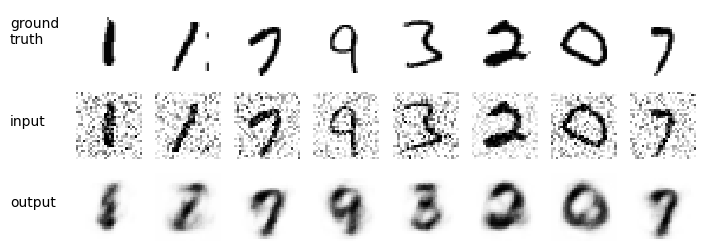

In [51]:
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state
import seaborn as sns

cols = 8
w = 1.0
fig, axs = plt.subplots(figsize=(cols*w, 3*w), ncols=cols, nrows=3)

rng = check_random_state(42)
for col, (upper, middle, lower) in enumerate(zip(axs[0], axs[1], axs[2])):
    if col == 0:
        upper.text(-28, 14, 'ground\ntruth')
        middle.text(-28, 14, 'input')
        lower.text(-28, 14, 'output')
    i = rng.choice(len(X_test))
    noisy = X_test[i].reshape(28, 28)
    clean = y_test[i].reshape(28, 28)
    clean_hat_i = clean_hat[i][1].reshape(28,28)
    kwargs = {'cbar': False, 'xticklabels': False, 'yticklabels': False, 'cmap': 'gray_r'}
    sns.heatmap(noisy, ax=middle, **kwargs)
    sns.heatmap(clean, ax=upper, **kwargs)
    sns.heatmap(clean_hat_i, ax=lower, **kwargs)
# plt.savefig("imgs/best-out.svg", bbox_inches="tight")
plt.show()

### Setting parameters for Hyperband
Need to know two things:

1. how many "epochs" or "passes through data" to train model
2. how many configs to evaluate
    * this is some measure of how complex the search space is
    
This determines

* The `max_iter` argument for `HyperbandCV`
* the chunks size for the array to pass in


## Comparison with early stopping

In [52]:
total_calls = search.metadata_['partial_fit_calls']
num_calls = max_iter

n_workers = 32 or len(client.cluster.workers)
num_models = max(n_workers, total_calls // num_calls)
num_calls, num_models, search.metadata_['partial_fit_calls']

(243, 32, 4743)

In [53]:
from dask_ml.model_selection import IncrementalSearchCV

passive_search = IncrementalSearchCV(
    model,
    params,
    decay_rate=0,
    patience=False,
    n_initial_parameters=num_models,
    max_iter=num_calls,
    random_state=42
)

In [54]:
passive_search.fit(X_train, y_train, **fit_params)

/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/dask_ml/model_selection/_incremental.py:1047: FutureWarning: decay_rate is deprecated in InverseDecaySearchCV. Use InverseDecaySearchCV to use decay_rate=0
  warn(
/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 418.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


steps = 1, loss = 2.0529050827026367
steps = 1, loss = 2.016209363937378
steps = 1, loss = 1.7782996892929077
steps = 1, loss = 0.7060245871543884
steps = 1, loss = 2.1401007175445557
steps = 1, loss = 1.039259433746338
steps = 1, loss = 1.5065793991088867
steps = 1, loss = 2.793207883834839
steps = 1, loss = 49.985382080078125
steps = 1, loss = 1.9677457809448242
steps = 1, loss = 1.7911102771759033
steps = 1, loss = 49.951480865478516
steps = 1, loss = 4.272833824157715
steps = 1, loss = 2.6291937828063965
steps = 1, loss = 2.4976720809936523
steps = 1, loss = 2.0125246047973633
steps = 1, loss = 0.714982271194458
steps = 1, loss = 1.979778528213501
steps = 1, loss = 1.9447377920150757
steps = 1, loss = 1.9673126935958862
steps = 1, loss = 2.038898468017578
steps = 1, loss = 2.4749724864959717
steps = 1, loss = 2.685521125793457
steps = 1, loss = 1.1485666036605835
steps = 1, loss = 1.9092943668365479
steps = 1, loss = 2.9808261394500732
steps = 1, loss = 2.307446241378784
steps = 1,

IncrementalSearchCV(decay_rate=0,
                    estimator=<class '__main__.TrimParams'>[uninitialized](
  module=<class 'autoencoder.Autoencoder'>,
),
                    max_iter=243, n_initial_parameters=32,
                    parameters={'batch_size': [32, 64, 128, 256, 512],
                                'module__activation': ['ReLU', 'LeakyReLU',
                                                       'ELU', 'PReLU'],
                                'module__init': ['xavier_uniform_',
                                                 'xavier_normal_',
                                                 'kaiming_uniform_',
                                                 'kaiming_norm...
       0.98098098, 0.98198198, 0.98298298, 0.98398398, 0.98498498,
       0.98598599, 0.98698699, 0.98798799, 0.98898899, 0.98998999,
       0.99099099, 0.99199199, 0.99299299, 0.99399399, 0.99499499,
       0.995996  , 0.996997  , 0.997998  , 0.998999  , 1.        ]),
                                'optimizer__nesterov': [True],
                                'optimizer__weight_decay': [0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, ...],
                                'train_split': [None]},
                    random_state=42)

In [55]:
save_search(passive_search, today, "passive", X_test.compute(), y_test.compute())

/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 209.35 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 44.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [56]:
timing_stats = client.profile()

with open("final-final-timings.json", "w") as f:
    json.dump(timing_stats, f)

* patience: `max_iter // 8` (10 epochs)
* n_initial: `2 * num_models`

This requires choosing

* the explore/exploit tradeoff (`patience` vs `n_initial`)
* some estimate on many models will take advantage of `patience` to get total number of partial fit calls

In [57]:
from dask_ml.model_selection import IncrementalSearchCV

patience_search = IncrementalSearchCV(
    model,
    params,
    decay_rate=0,
    patience=max_iter // 10,
    n_initial_parameters=2 * num_models,
    max_iter=num_calls,
    random_state=42,
)

In [58]:
patience_search.fit(X_train, y_train, **fit_params)

/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/dask_ml/model_selection/_incremental.py:1047: FutureWarning: decay_rate is deprecated in InverseDecaySearchCV. Use InverseDecaySearchCV to use decay_rate=0
  warn(
/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 418.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


steps = 1, loss = 1.977994441986084
steps = 1, loss = 1.3603099584579468
steps = 1, loss = 2.838804006576538
steps = 1, loss = 2.043135643005371
steps = 1, loss = 1.6521202325820923
steps = 1, loss = 50.01109313964844
steps = 1, loss = 2.415562391281128
steps = 1, loss = 1.870324969291687
steps = 1, loss = 49.96464538574219
steps = 1, loss = 2.2370715141296387
steps = 1, loss = 1.9614841938018799
steps = 1, loss = 2.0443553924560547
steps = 1, loss = 1.9816150665283203
steps = 1, loss = 2.5164997577667236
steps = 1, loss = 2.497925281524658
steps = 1, loss = 2.5560879707336426
steps = 1, loss = 2.4865505695343018
steps = 1, loss = 49.804935455322266
steps = 1, loss = 1.912054181098938
steps = 1, loss = 2.76041841506958
steps = 1, loss = 3.190953016281128
steps = 1, loss = 2.2113561630249023
steps = 1, loss = 0.8000869154930115
steps = 1, loss = 2.2022204399108887
steps = 1, loss = 1.941310167312622
steps = 1, loss = 2.932598829269409
steps = 1, loss = 0.7037603259086609
steps = 1, loss

IncrementalSearchCV(decay_rate=0,
                    estimator=<class '__main__.TrimParams'>[uninitialized](
  module=<class 'autoencoder.Autoencoder'>,
),
                    max_iter=243, n_initial_parameters=64,
                    parameters={'batch_size': [32, 64, 128, 256, 512],
                                'module__activation': ['ReLU', 'LeakyReLU',
                                                       'ELU', 'PReLU'],
                                'module__init': ['xavier_uniform_',
                                                 'xavier_normal_',
                                                 'kaiming_uniform_',
                                                 'kaiming_norm...
       0.98098098, 0.98198198, 0.98298298, 0.98398398, 0.98498498,
       0.98598599, 0.98698699, 0.98798799, 0.98898899, 0.98998999,
       0.99099099, 0.99199199, 0.99299299, 0.99399399, 0.99499499,
       0.995996  , 0.996997  , 0.997998  , 0.998999  , 1.        ]),
                                'optimizer__nesterov': [True],
                                'optimizer__weight_decay': [0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, ...],
                                'train_split': [None]},
                    patience=24, random_state=42)

In [59]:
patience_search.best_score_

-1.9024713039398193

In [60]:
save_search(patience_search, today, "patience", X_test.compute(), y_test.compute())

/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 209.35 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/barradd/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 32.84 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [61]:
timing_stats = client.profile()

In [62]:
with open("final-timings.json", "w") as f:
    json.dump(timing_stats, f)

In [63]:
data, fig = client.get_task_stream(plot=True)

In [64]:
len(data)

19232

In [65]:
fig

figure(id='p2109941', ...)

In [ ]:
saved_ = Out[46]

In [66]:
import pandas as pd
df = pd.DataFrame(list(data))

In [67]:
df.head()

,stimulus_id,worker,nbytes,type,typename,metadata,thread,startstops,status,key
0,task-finished-1706678416.9221444,tcp://127.0.0.1:41087,2153,b'\x80\x05\x95\x16\x00\x00\x00\x00\x00\x00\x00...,tuple,{},139900515796736,"({'action': 'compute', 'start': 1706678318.965...",OK,_partial_fit-bf707c36-2316-4ab5-aa62-fa3d4a417c1a
1,task-finished-1706678513.142254,tcp://127.0.0.1:41087,2153,b'\x80\x05\x95\x16\x00\x00\x00\x00\x00\x00\x00...,tuple,{},139900515796736,"({'action': 'compute', 'start': 1706678416.979...",OK,_partial_fit-2d2b8d50-e8bd-44a6-b33c-8f8a98047c18
2,task-finished-1706678613.2071962,tcp://127.0.0.1:39149,2153,b'\x80\x05\x95\x16\x00\x00\x00\x00\x00\x00\x00...,tuple,{},140578566170368,"({'action': 'transfer', 'start': 1706678513.03...",OK,_partial_fit-c3350e1e-48dc-4a28-8dc6-f081a97aa134
3,task-finished-1706678711.4727633,tcp://127.0.0.1:41087,2153,b'\x80\x05\x95\x16\x00\x00\x00\x00\x00\x00\x00...,tuple,{},139900515796736,"({'action': 'transfer', 'start': 1706678613.21...",OK,_partial_fit-e79c3045-b3e9-4002-896f-6d5688cf6357
4,task-finished-1706678810.3910055,tcp://127.0.0.1:41087,2153,b'\x80\x05\x95\x16\x00\x00\x00\x00\x00\x00\x00...,tuple,{},139900515796736,"({'action': 'compute', 'start': 1706678711.526...",OK,_partial_fit-80b04eb1-fd1c-4e3f-a2b3-4c3eee1a78b9


In [68]:
df.to_.to_msgpack("times.msgpack")

AttributeError: 'DataFrame' object has no attribute 'to_msgpack'

In [69]:
type(data)

tuple

In [70]:
len(data)

19232